This notebook is based on matlab code provided through the course "Monte Carlo Methods in Finance". 

https://iversity.org/my/courses/monte-carlo-methods-in-finance/

I attempt to convert all matlab code to a Python version, and try to stay as close as possible as the original implementation. Of course, in many cases I make use of the functionality of Python libraries, such as NumPy, SciPy and pandas. 

To ensure you have all these packages (correctly) installed I recommend installing Python + all relevant packages through a package manager, such as Anaconda, Python(X,Y) or Enthought Canopy.

In [1]:
from __future__ import division
import numpy as np
import pandas as pd

# Week 1

## europeanOption -- demo 1

In this demonstration the price of a European asset is determined through an expected payoff function. This model assumes stocks are described through a log normal distribution.

The payoff function is passed as an argument to the pricing function 'priceEuropeanOption'.

In [2]:
# quad is a numerical integrator. You pass it a function and integration limits.
from scipy.integrate import quad

# this object 'norm' is be used to calculate the PDF or CDF or other properties of the normal distribution
from scipy.stats import norm 

def priceEuropeanOption(S0,r,T,sigma,payoff):
    def ST(x):
        return S0 * np.exp( (r-.5 * sigma**2) * T + sigma * np.sqrt(T) * x )
    R = 10
    def integrand(x):
        return norm.pdf(x) * payoff(ST(x))
    discountFactor = np.exp(-r*T)
    return discountFactor * quad( integrand , -R, R)[0] 

#### demo_priceEuropeanOption_asset: Pricing the asset

Sanity check: the pricing of a stock using priceEuropeanOption should equal its initial price S0.

In [3]:
def demo_priceEuropeanOption_asset():
    S0 = 100
    sigma = .4
    T = 2
    def payoff(ST):
        return ST
    r = .05
    return priceEuropeanOption(S0,r,T,sigma,payoff)

print demo_priceEuropeanOption_asset()

100.0


#### demo_priceEuropeanOption_call: Price of a European call option

Two demonstrations: the price of a European Call Option (the right but not the obligation to buy the stock at strike K at maturity T) and the pricing of a normal stock. 

In [4]:
def demo_priceEuropeanOption_call():
    S0 = 100
    sigma = .4
    K = 90
    T = 2
    def payoff(ST):
        return np.max([ST - K, 0])
    r = .05
    return priceEuropeanOption(S0,r,T,sigma,payoff)


print demo_priceEuropeanOption_call()

30.761890184


## investmentPortfolio -- demo 2

This demonstration constructs a portfolio of three stocks.

This requires stock data, which we can load from the yahoo website using the pandas library.

In [28]:
import pandas_datareader.data as web
from datetime import datetime
start = datetime(2015, 2, 9)
end = datetime(2017, 5, 24)
f = web.DataReader('F', 'yahoo', start, end)['Adj Close']
f.head()

Date
2015-02-09    13.507221
2015-02-10    13.651458
2015-02-11    13.787210
2015-02-12    13.880536
2015-02-13    13.829631
Name: Adj Close, dtype: float64

In [38]:
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

import fix_yahoo_finance as yf
yf.pdr_override() # <== that's all it takes :-)

# download dataframe
data = pdr.get_data_yahoo("SPY", start="2007-07-01", end="2013-06-30")

# download Panel
S = pdr.get_data_yahoo(["IBM", "GOOG", "MSFT"], start="2007-07-01", end="2013-06-30")['Adj Close']
S.count()


[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  3 of 3 downloaded


GOOG    1510
IBM     1510
MSFT    1510
dtype: int64

In [39]:
S.head()

,GOOG,IBM,MSFT
Date,,,
2007-07-02,263.476349,78.932228,22.820421
2007-07-03,265.443542,80.112328,23.035275
2007-07-05,269.065002,81.217270,23.012257
2007-07-06,267.957184,81.953911,22.996904
2007-07-09,269.526978,81.908783,22.920174


In [40]:
S.plot();

In [41]:
initialValue = 100
normalizedS = initialValue * S / S.ix[0]
normalizedS.plot();

/home/vijay/miniconda3/envs/montecarloinfinance/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


#### demo_investmentPortfolio: Time series of portfolio values from the series of asset prices.

/home/vijay/miniconda3/envs/montecarloinfinance/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


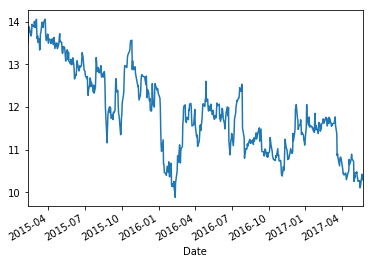

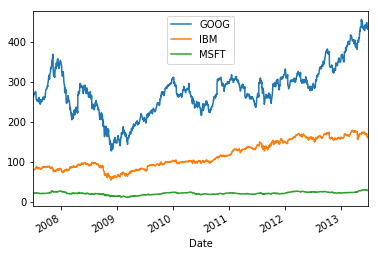

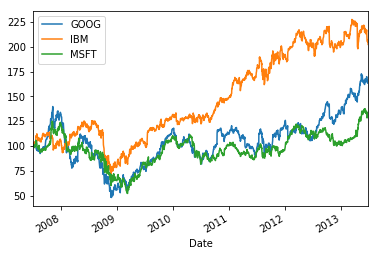

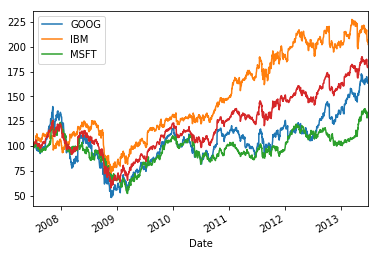

In [43]:
# define composition of portfolio 
c = [500, 200, 200]
# construct time series of portfolio; we use the list to ensure the order of the stock matches
P = (S[["IBM", "GOOG", "MSFT"]] * c).sum(axis = 1)
# and normalize
normalizedP = initialValue * P / P.ix[0]

normalizedP.name = "Portfolio"

plt.figure();
normalizedS.plot();
normalizedP.plot();
plt.show();

In [63]:
w = (S[["IBM", "GOOG", "MSFT"]] * c) / P.ix[0]
w.plot();

## Returns -- demo 3

#### demo_Bachelier_BlackScholes: Compare Bachelier and Black-Scholes models

In [46]:
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

import fix_yahoo_finance as yf
yf.pdr_override() # <== that's all it takes :-)

# download dataframe
data = pdr.get_data_yahoo("SPY", start="2007-07-01", end="2013-06-30")

# download Panel
S = pdr.get_data_yahoo(["IBM", "GOOG", "MSFT"], start="2007-07-01", end="2013-06-30")['Adj Close']

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  3 of 3 downloaded


Defining the changes dS and the log changes r. We combine these into a single dataframe

In [47]:
Stocks = S.join(S.diff(), rsuffix='_diff' )
Stocks = Stocks.join(np.log(S).diff(), rsuffix='_log_diff' )
Stocks.head()

,GOOG,IBM,MSFT,GOOG_diff,IBM_diff,MSFT_diff,GOOG_log_diff,IBM_log_diff,MSFT_log_diff
Date,,,,,,,,,
2007-07-02,263.476349,78.932228,22.820421,NaN,NaN,NaN,NaN,NaN,NaN
2007-07-03,265.443542,80.112328,23.035275,1.967193,1.180100,0.214854,0.007439,0.014840,0.009371
2007-07-05,269.065002,81.217270,23.012257,3.621460,1.104942,-0.023018,0.013551,0.013698,-0.001000
2007-07-06,267.957184,81.953911,22.996904,-1.107818,0.736641,-0.015353,-0.004126,0.009029,-0.000667
2007-07-09,269.526978,81.908783,22.920174,1.569794,-0.045128,-0.076730,0.005841,-0.000551,-0.003342


Make a list of the columns which correspond to returns.

In [49]:
returns = [colnames for colnames in Stocks.columns if colnames.endswith('_diff') ]

In [50]:
nBins = 100
R = 10
Bins = np.linspace(-R, R, nBins)

# This function computes and plots the histogram, and returns axis objects for each figure
# The axis objects can be used to set things like plotranges and titles.
axes = (Stocks[returns] / (Stocks[returns].quantile(.75) - Stocks[returns].quantile(.25) )).hist(\
                bins = Bins, figsize=(10, S.columns.size * 5), facecolor='w', edgecolor='k', layout = (S.columns.size, 2));
for ax in axes.flatten(): 
    ax.set_xlim(left = -R, right = R) # enforces axis limits
    ax.set_title(ax.get_title() + '_normalized')

#### demo_logReturns: Properties of log returns in a time series

Here we determine and plot the log returns of the stock data.

In [51]:
# As the name suggests, we use the shift operator to shift the index of S. This computes S[1:] / S[:-1]. 
Stocks = S.join( np.log(S / S.shift(1)), rsuffix='_logreturns' )
Stocks.head()

,GOOG,IBM,MSFT,GOOG_logreturns,IBM_logreturns,MSFT_logreturns
Date,,,,,,
2007-07-02,263.476349,78.932228,22.820421,NaN,NaN,NaN
2007-07-03,265.443542,80.112328,23.035275,0.007439,0.014840,0.009371
2007-07-05,269.065002,81.217270,23.012257,0.013551,0.013698,-0.001000
2007-07-06,267.957184,81.953911,22.996904,-0.004126,0.009029,-0.000667
2007-07-09,269.526978,81.908783,22.920174,0.005841,-0.000551,-0.003342


In [52]:
# To fix the order of plotting we construct a list
column_order = []
for i in S.columns: column_order.extend([i, i + '_logreturns'])

In [54]:
# The list column_order selects the columns of Stocks in a particular order. No data is copied in this process.
axes = Stocks[column_order].plot(subplots=True, figsize=(10, S.columns.size * 5))

#### demo_simpleReturns: Properties of returns in a time series

Here we also include the ordinary returns of the stocks, and construct a portfolio.

In [55]:
Stocks = Stocks.join( S / S.shift(1), rsuffix='_returns' )
Stocks.head()

,GOOG,IBM,MSFT,GOOG_logreturns,IBM_logreturns,MSFT_logreturns,GOOG_returns,IBM_returns,MSFT_returns
Date,,,,,,,,,
2007-07-02,263.476349,78.932228,22.820421,NaN,NaN,NaN,NaN,NaN,NaN
2007-07-03,265.443542,80.112328,23.035275,0.007439,0.014840,0.009371,1.007466,1.014951,1.009415
2007-07-05,269.065002,81.217270,23.012257,0.013551,0.013698,-0.001000,1.013643,1.013792,0.999001
2007-07-06,267.957184,81.953911,22.996904,-0.004126,0.009029,-0.000667,0.995883,1.009070,0.999333
2007-07-09,269.526978,81.908783,22.920174,0.005841,-0.000551,-0.003342,1.005858,0.999449,0.996663


In [56]:
# To fix the order of plotting we construct a list
column_order = []
for i in S.columns: column_order.extend([i, i + '_returns'])

In [57]:
Stocks[column_order].plot(subplots=True, figsize=(10, S.columns.size * 5));

Next we look at a portfolio P, and plot its return

In [59]:
# portfolio weight
c = [500, 200, 200] 

# add portfolio to Stocks
Stocks['P'] = (S[["IBM", "GOOG", "MSFT"]] * c).sum(axis = 1)

# and compute the return of the portfolio
Stocks['P_returns'] = 100 * ( Stocks['P'] / Stocks['P'].shift(1) - 1)
Stocks.head()

,GOOG,IBM,MSFT,GOOG_logreturns,IBM_logreturns,MSFT_logreturns,GOOG_returns,IBM_returns,MSFT_returns,P,P_returns
Date,,,,,,,,,,,
2007-07-02,263.476349,78.932228,22.820421,NaN,NaN,NaN,NaN,NaN,NaN,96725.4680,NaN
2007-07-03,265.443542,80.112328,23.035275,0.007439,0.014840,0.009371,1.007466,1.014951,1.009415,97751.9274,1.061209
2007-07-05,269.065002,81.217270,23.012257,0.013551,0.013698,-0.001000,1.013643,1.013792,0.999001,99024.0868,1.301416
2007-07-06,267.957184,81.953911,22.996904,-0.004126,0.009029,-0.000667,0.995883,1.009070,0.999333,99167.7731,0.145102
2007-07-09,269.526978,81.908783,22.920174,0.005841,-0.000551,-0.003342,1.005858,0.999449,0.996663,99443.8219,0.278365


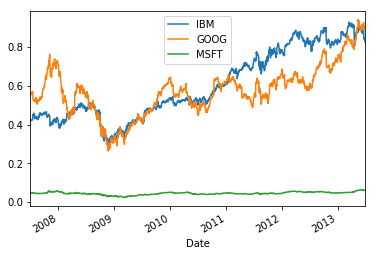

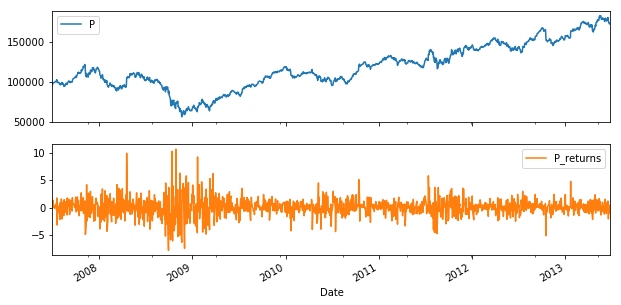

In [64]:
# A plot of how our portfolio is performing
plt.figure()
Stocks[['P','P_returns']].plot(subplots=True, figsize=(10,  5));
plt.show()